# Heart Failure Clinical Records
This notebook will take the cleaned data and create, train, and save various machine learning models.

All of the models will be implemented using a pipeline and search so that it can be exported and easily used in a Flask application.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pulling in age provides a better outcome, and age was next on the priority list after these two (disregarding time).
all_data = pd.read_csv('./data/cleaned.csv', usecols=['serum_creatinine', 'ejection_fraction', 'age', 'DEATH_EVENT'])

In [2]:
# DEBUG: Convert columns back to regular values for inspection. np.log() was applied, so np.exp() undoes it.
# all_data['serum_creatinine'] = np.exp(all_data.serum_creatinine)
# all_data['ejection_fraction'] = np.exp(all_data.ejection_fraction)

## Data Preparation
Splitting the data into train and test sets.  Values are chosen arbitrarily but sensibly.

In [3]:
from sklearn.model_selection import train_test_split

X = all_data.drop('DEATH_EVENT', axis=1)
y = all_data['DEATH_EVENT']

TEST_SIZE = 0.3
RANDOM_STATE = 4242
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [4]:
# DEBUG: Pull some values out to test them in the deployed API.
# np.exp(...)
# print(X_test.iloc[2])
# print(y_test.iloc[2])

## Resolving Imbalanced Data (Optional)

In [5]:
# Roughly taken from:
# https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

RESAMPLE_METHOD = 'synthetic' # ['oversample', 'synthetic', emptystr for none]

# Oversampling minority class using sklearn.
if RESAMPLE_METHOD == 'oversample':
    print('Resampling enabled; original balance:')
    print(y_train.value_counts())
    
    # Join training data back together.
    resamp_joined = pd.concat([X_train, y_train], axis=1)

    # Separate classes.
    resamp_died = resamp_joined[resamp_joined['DEATH_EVENT'] == 1]
    resamp_survived = resamp_joined[resamp_joined['DEATH_EVENT'] == 0]

    # Upsample minority (died).
    resamp_died_upsampled = resample(
        resamp_died,
        replace=True, # (use replacement)
        n_samples=len(resamp_survived), # (match number of majority cases)
        random_state=RANDOM_STATE
    )

    # Combine majority and upsampled majority.
    resamp_upsampled = pd.concat([resamp_survived, resamp_died_upsampled])

    # Check class counts.
    print('Resampling complete; new balance:')
    print(resamp_upsampled['DEATH_EVENT'].value_counts())

    # Remake X_train, y_train.
    X_train = resamp_upsampled.drop('DEATH_EVENT', axis=1)
    y_train = resamp_upsampled['DEATH_EVENT']

# Generating synthetic samples using imblearn SMOTE.
if RESAMPLE_METHOD == 'synthetic':
    print('Synthetic sampling enabled; original balance:')
    print(y_train.value_counts())
    
    smote = SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')
    X_train, y_train = smote.fit_sample(X_train, y_train)
    
    print('Synthetic sampling complete; new balance:')
    print(y_train.value_counts())

Synthetic sampling enabled; original balance:
0    142
1     67
Name: DEATH_EVENT, dtype: int64
Synthetic sampling complete; new balance:
1    142
0    142
Name: DEATH_EVENT, dtype: int64


## Helper Functions

Prints out some scoring statistics and most successful parameters for a cross-validation object.

In [6]:
def print_cv_stats(cv):
    mean_accuracy = np.mean(cv.cv_results_['mean_test_accuracy'])
    print(f'Mean Accuracy: {mean_accuracy}')
    
    mean_f1 = np.mean(cv.cv_results_['mean_test_f1'])
    print(f'Mean F1: {mean_f1}')

    mean_roc = np.mean(cv.cv_results_['mean_test_roc_auc'])
    print(f'Mean ROC AUC: {mean_roc}')

    print(f'Best Params: {cv.best_params_}')

Prints out scoring statistics and a confusion matrix for a model's predictions.

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

def print_model_stats(actuals, preds):
    # Basic scoring using sklearn.
    print(f'Accuracy: {accuracy_score(actuals, preds)}')
    print(f'F1 Score: {f1_score(actuals, preds)}')
    print(f' ROC AUC: {roc_auc_score(actuals, preds)}')
    
    # Scoring using a manual confusion matrix (https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872).
    cnf_matrix = confusion_matrix(actuals, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) # Model incorrectly predicts positive class.
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix) # Model incorrectly predicts negative class.
    TP = np.diag(cnf_matrix) # Model correctly predicts positive class.
    TN = cnf_matrix.sum() - (FP + FN + TP) # Model correctly predicts negative class.
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy for each class
    ACC = (TP+TN)/(TP+FP+FN+TN)
    #
    print()
    # These are printed for each class in an array.
    print(f'Sensitivity: {TPR}')
    print(f'Specificity: {TNR}')
    print(f'Precision: {PPV}')
    print(f'Negative predictive value: {NPV}')
    print(f'False positive rate: {FPR}')
    print(f'False negative rate: {FNR}')
    print(f'False discovery rate: {FDR}')
    print(f'Accuracy: {ACC}')
    
    # Could build this from the confusion matrix with index and column names set, but it looks better this way.
    sns.heatmap(pd.crosstab(actuals, preds, rownames=['Actual'], colnames=['Predic']), annot=True)
    plt.show()

Draws a learning curve to help visualize model progress and quality over time.

In [8]:
# Modified version of this https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, rstate, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True,
        shuffle=True, # Without this it sometimes breaks!
        random_state=rstate # Needed when shuffle=True for consistency.
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Modeling

In [9]:
# Common imports for the models that follow.
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib # For saving the results out.

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
kfold = StratifiedKFold(n_splits=3) # Shuffling the data then splitting seemed to work best.
# kfold = StratifiedShuffleSplit(n_splits=3)
# kfold = KFold(n_splits=3)

# I have also tried LOOCV but it was not worth the extra time.
# from sklearn.model_selection import LeaveOneOut
# loo = LeaveOneOut()

In [10]:
# https://scikit-learn.org/stable/modules/model_evaluation.html
# https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

# All metrics that will be reported.
SCORING_METRICS = [
    'accuracy', # Doesn't work well on imbalanced data (ignore if balancing above), but nice to have around.
    'f1',       # Precision+Recall combined (kinda). Perfect for binary classification, which is what we have.
    'roc_auc'   # Again good for classification (TPR & FPR), but not good with imbalanced datasets.
]

# The main metric to optimize for.
MAIN_METRIC = 'f1'

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Pipeline.
pl_logreg = Pipeline([
    ('sc', StandardScaler()),
    ('lr', LogisticRegression())
])

# Randomized search space (in this case it's fast enough to basically be a grid search).
params_logreg = {
    'lr__C': np.linspace(0.0001, 1.0, 30),
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [100, 200, 400],
    'lr__solver': ['liblinear'], # Good for small datasets.
    'lr__random_state': [RANDOM_STATE]
}
cv_logreg = RandomizedSearchCV(
    pl_logreg,
    params_logreg,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=180, n_jobs=-1
)

# Fit to train data.
cv_logreg.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('lr', LogisticRegression())]),
                   n_iter=180, n_jobs=-1,
                   param_distributions={'lr__C': array([1.00000000e-04, 3.45793103e-02, 6.90586207e-02, 1.03537931e-01,
       1.38017241e-01, 1.72496552e-01, 2.06975862e-01, 2.41455172e-01,
       2.75934483e...
       5.51768966e-01, 5.86248276e-01, 6.20727586e-01, 6.55206897e-01,
       6.89686207e-01, 7.24165517e-01, 7.58644828e-01, 7.93124138e-01,
       8.27603448e-01, 8.62082759e-01, 8.96562069e-01, 9.31041379e-01,
       9.65520690e-01, 1.00000000e+00]),
                                        'lr__max_iter': [100, 200, 400],
                                        'lr__penalty': ['l1', 'l2'],
                                        'lr__random_state': [4242],
                                        'lr__sol

Mean Accuracy: 0.7129955207166853
Mean F1: 0.6859995442818702
Mean ROC AUC: 0.7788484713210267
Best Params: {'lr__solver': 'liblinear', 'lr__random_state': 4242, 'lr__penalty': 'l2', 'lr__max_iter': 100, 'lr__C': 0.03457931034482759}


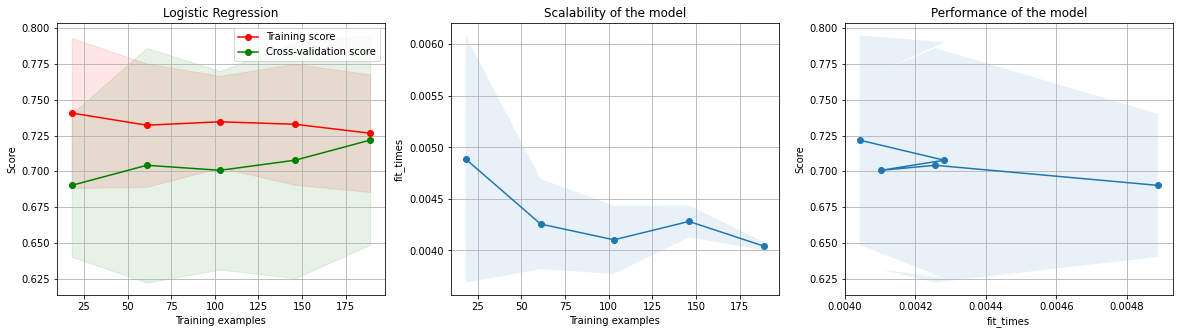

In [12]:
# Stats from the CV fit.
print_cv_stats(cv_logreg)

# Plot learning curves for visual investigation.
plot_learning_curve(cv_logreg.best_estimator_, 'Logistic Regression', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.7555555555555555
F1 Score: 0.6857142857142856
 ROC AUC: 0.7744488411531939

Sensitivity: [0.72131148 0.82758621]
Specificity: [0.82758621 0.72131148]
Precision: [0.89795918 0.58536585]
Negative predictive value: [0.58536585 0.89795918]
False positive rate: [0.17241379 0.27868852]
False negative rate: [0.27868852 0.17241379]
False discovery rate: [0.10204082 0.41463415]
Accuracy: [0.75555556 0.75555556]


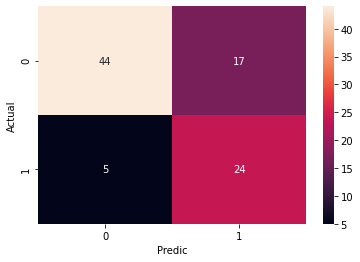

In [13]:
# Make predictions with test set and check more stats.
preds_logreg = cv_logreg.predict(X_test)
print_model_stats(y_test, preds_logreg)

In [14]:
# Export the CV(/pipeline/model/scaler).
joblib.dump(cv_logreg, 'logreg.pkl')

['logreg.pkl']

### SVC

In [15]:
from sklearn.svm import SVC

pl_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
params_svc = {
    'svc__C': np.linspace(0.0001, 1.0, 30),
    'svc__gamma': np.linspace(0.0001, 1.0, 30),
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
cv_svc = RandomizedSearchCV(
    pl_svc,
    params_svc,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=150, n_jobs=-1
)
cv_svc.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svc', SVC(probability=True))]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'svc__C': array([1.00000000e-04, 3.45793103e-02, 6.90586207e-02, 1.03537931e-01,
       1.38017241e-01, 1.72496552e-01, 2.06975862e-01, 2.41455172e-01,
       2.75...
       4.13851724e-01, 4.48331034e-01, 4.82810345e-01, 5.17289655e-01,
       5.51768966e-01, 5.86248276e-01, 6.20727586e-01, 6.55206897e-01,
       6.89686207e-01, 7.24165517e-01, 7.58644828e-01, 7.93124138e-01,
       8.27603448e-01, 8.62082759e-01, 8.96562069e-01, 9.31041379e-01,
       9.65520690e-01, 1.00000000e+00]),
                                        'svc__kernel': ['linear', 'poly', 'rbf',
                                                        'sigmoid']},
                   random_state=4242,

Mean Accuracy: 0.6785601592634068
Mean F1: 0.6348903713113927
Mean ROC AUC: 0.7577823047130426
Best Params: {'svc__kernel': 'rbf', 'svc__gamma': 1.0, 'svc__C': 0.758644827586207}


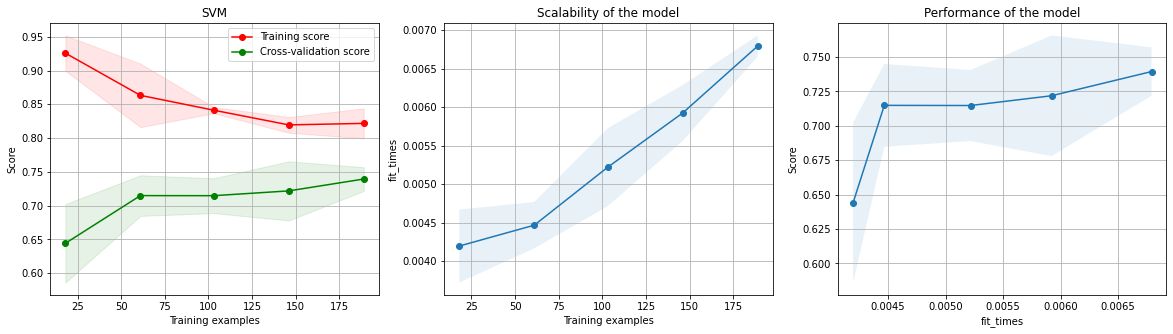

In [16]:
print_cv_stats(cv_svc)

plot_learning_curve(cv_svc.best_estimator_, 'SVM', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.7444444444444445
F1 Score: 0.6666666666666666
 ROC AUC: 0.757207461842849

Sensitivity: [0.72131148 0.79310345]
Specificity: [0.79310345 0.72131148]
Precision: [0.88  0.575]
Negative predictive value: [0.575 0.88 ]
False positive rate: [0.20689655 0.27868852]
False negative rate: [0.27868852 0.20689655]
False discovery rate: [0.12  0.425]
Accuracy: [0.74444444 0.74444444]


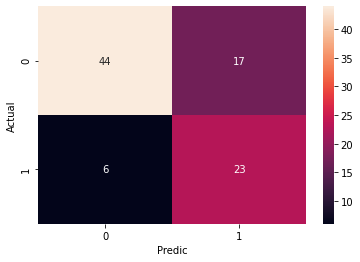

In [17]:
preds_svc = cv_svc.predict(X_test)
print_model_stats(y_test, preds_svc)

In [18]:
joblib.dump(cv_svc, 'svm.pkl')

['svm.pkl']

### Gradient Boosting

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

pl_gboost = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])
params_gboost = {
    'gb__n_estimators': [100, 200, 400],
    'gb__max_features': ['log2', 'auto'],
    'gb__min_samples_leaf': [1, 2, 3],
    'gb__learning_rate': np.linspace(0.001, 1.0, 30),
    'gb__max_depth': [2, 4, 6, 8, 10]
}
cv_gboost = RandomizedSearchCV(
    pl_gboost,
    params_gboost,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=150, n_jobs=-1
)
cv_gboost.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'gb__learning_rate': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.3...
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ]),
                                        'gb__max_depth': [2, 4, 6, 8, 10],
                                        'gb__max_features': ['log2', 'auto'],
                                        'gb__min_samples_leaf': [1, 2, 3],
                           

Mean Accuracy: 0.7907955704865
Mean F1: 0.7805650506576444
Mean ROC AUC: 0.8643996361685362
Best Params: {'gb__n_estimators': 200, 'gb__min_samples_leaf': 3, 'gb__max_features': 'log2', 'gb__max_depth': 10, 'gb__learning_rate': 0.035448275862068966}


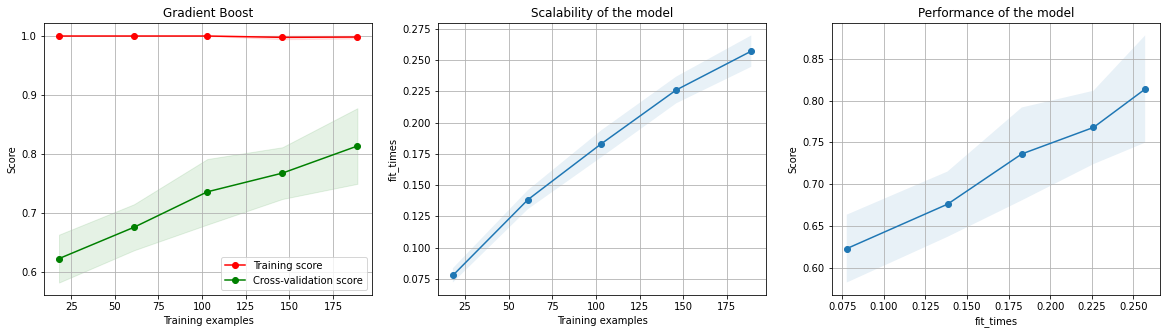

In [20]:
print_cv_stats(cv_gboost)

plot_learning_curve(cv_gboost.best_estimator_, 'Gradient Boost', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.7666666666666667
F1 Score: 0.6315789473684211
 ROC AUC: 0.7283776144714528

Sensitivity: [0.83606557 0.62068966]
Specificity: [0.62068966 0.83606557]
Precision: [0.82258065 0.64285714]
Negative predictive value: [0.64285714 0.82258065]
False positive rate: [0.37931034 0.16393443]
False negative rate: [0.16393443 0.37931034]
False discovery rate: [0.17741935 0.35714286]
Accuracy: [0.76666667 0.76666667]


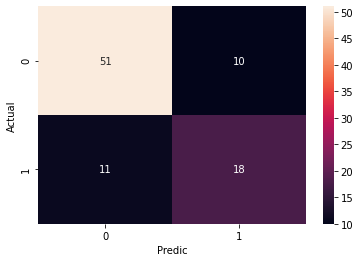

In [21]:
preds_gboost = cv_gboost.predict(X_test)
print_model_stats(y_test, preds_gboost)

In [22]:
joblib.dump(cv_gboost, 'gboost.pkl')

['gboost.pkl']

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

pl_forest = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
params_forest = {
    'rf__n_estimators': [200, 400, 800, 1000],
    'rf__max_features': ['auto', 2, 3],
    'rf__min_samples_leaf': [1, 2, 5, 10],
    'rf__max_depth': [4, 8, 16, 32],
    'rf__min_samples_split': [2, 5, 10, 15]
}
cv_forest = RandomizedSearchCV(
    pl_forest,
    params_forest,
    cv=kfold, scoring=SCORING_METRICS, refit=MAIN_METRIC, random_state=RANDOM_STATE, n_iter=150, n_jobs=-1
)
cv_forest.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'rf__max_depth': [4, 8, 16, 32],
                                        'rf__max_features': ['auto', 2, 3],
                                        'rf__min_samples_leaf': [1, 2, 5, 10],
                                        'rf__min_samples_split': [2, 5, 10, 15],
                                        'rf__n_estimators': [200, 400, 800,
                                                             1000]},
                   random_state=4242, refit='f1',
                   scoring=['accuracy', 'f1', 'roc_auc'])

Mean Accuracy: 0.7447836257309942
Mean F1: 0.735601262054166
Mean ROC AUC: 0.8281740208406686
Best Params: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 3, 'rf__max_depth': 32}


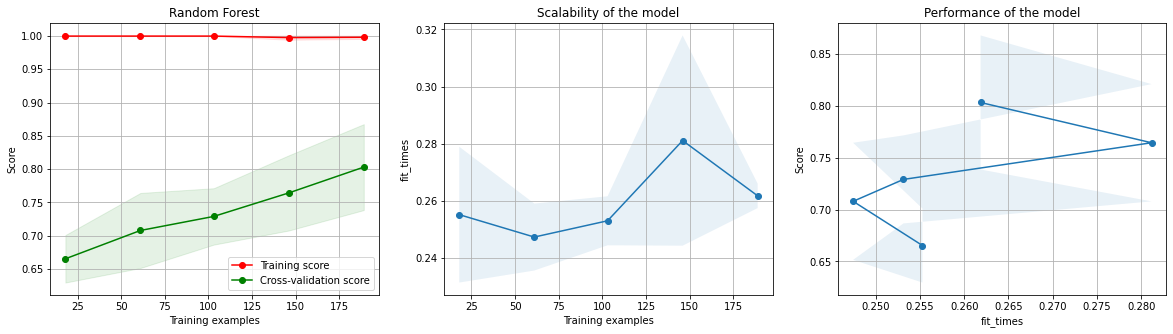

In [24]:
print_cv_stats(cv_forest)

plot_learning_curve(cv_forest.best_estimator_, 'Random Forest', X_train, y_train, RANDOM_STATE, cv=kfold)
plt.show()

Accuracy: 0.7
F1 Score: 0.5846153846153845
 ROC AUC: 0.6882419446014698

Sensitivity: [0.72131148 0.65517241]
Specificity: [0.65517241 0.72131148]
Precision: [0.81481481 0.52777778]
Negative predictive value: [0.52777778 0.81481481]
False positive rate: [0.34482759 0.27868852]
False negative rate: [0.27868852 0.34482759]
False discovery rate: [0.18518519 0.47222222]
Accuracy: [0.7 0.7]


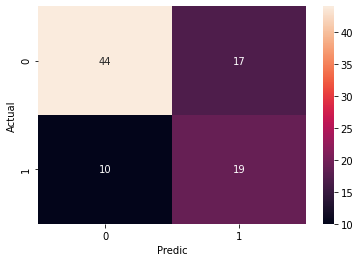

In [25]:
preds_forest = cv_forest.predict(X_test)
print_model_stats(y_test, preds_forest)

In [26]:
joblib.dump(cv_forest, 'forest.pkl')

['forest.pkl']

## Play Area
Experimenting and/or debugging.

In [27]:
# from sklearn.ensemble import VotingClassifier

# voting = VotingClassifier(estimators=[
#     ('logreg', cv_logreg.best_estimator_),
#     ('svc', cv_svc.best_estimator_),
#     ('gboost', cv_gboost.best_estimator_)
# ], voting='soft', n_jobs=-1)

# voting = voting.fit(X_train, y_train)

In [28]:
# preds_voting = voting.predict(X_test)
# print_model_stats(y_test, preds_voting)